In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.metrics import accuracy_score


class MACPredictorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super(MACPredictorLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers,
            batch_first=True,
            dropout=dropout_rate, 
            bidirectional=False
        )
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        
        out = self.fc(out)
        
        return out

def load_data(file_path):
    df = pd.read_json(file_path, lines=True)
    df = df.drop(columns=['d_mac'])
    df = df.fillna(0.0)
    return df

def encode_target(df, le=None, is_train=True):
    # Initialize LabelEncoder for training, or use existing one for testing
    if is_train:
        le = LabelEncoder()
        df['s_mac_encoded'] = le.fit_transform(df['s_mac'])
        num_classes = len(le.classes_)
        return df.drop(columns=['s_mac']), num_classes, le
    else:
        # handle case where mac address seen in test but not in case
        from collections import Counter
        print("Source mac address counts: ")
        print(Counter(df['s_mac'])['14:cc:20:51:33:ea'])
        df['s_mac_encoded'] = le.transform(df['s_mac'])
        return df.drop(columns=['s_mac']), None, le

def scale_features(df, scaler=None, is_train=True):
    # Identify numerical features (all columns except the encoded target)
    feature_cols = [col for col in df.columns if col != 's_mac_encoded']
    
    if is_train:
        scaler = MinMaxScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])
        return df, scaler, feature_cols
    else:
        # Use existing scaler, only transform.
        df[feature_cols] = scaler.transform(df[feature_cols])
        return df, scaler, feature_cols

def create_sequences(df, look_back):
    feature_cols = [col for col in df.columns if col != 's_mac_encoded']
    data = df[feature_cols].values
    target = df['s_mac_encoded'].values
    
    X, Y = [], []
    for i in range(look_back, len(df)):
        X.append(data[i - look_back:i, :])
        Y.append(target[i])

    return np.array(X), np.array(Y)

class MACDataset(Dataset):
    #convert to tensors
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).long() 
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
    """Trains the LSTM model."""
    model.train()
    print(f"\n--- Starting Training on {device} for {num_epochs} epochs ---")
    start_time = time.time()

    train_loss = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (sequences, labels) in enumerate(train_loader):
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        train_loss[epoch] = avg_loss
        #print(train_loss)

    end_time = time.time()
    print(f"Training Complete. Total time: {(end_time - start_time):.2f}s")
    return train_loss

In [ ]:
def evaluate_model(model, test_loader, device, label_encoder):
    model.eval()
    print("\n--- Starting Evaluation ---")
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences)
            
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    
    try:
        sample_true_mac = label_encoder.inverse_transform(y_true)
        sample_pred_mac = label_encoder.inverse_transform(y_pred)
    except ValueError:
        sample_true_mac = [f"Encoded: {i}" for i in y_true]
        sample_pred_mac = [f"Encoded: {i}" for i in y_pred]


    print(f"Classification Accuracy: {accuracy*100:.2f}%")
    print("\nSample Predictions:")
    print(pd.DataFrame({'True MAC': sample_true_mac, 'Predicted MAC': sample_pred_mac}))
    return sample_true_mac, sample_pred_mac

In [ ]:

TRAIN_FILE = 'all_features_with_mac_part1_80.jsonl'
TEST_FILE = 'all_features_with_mac_part2_20.jsonl'

LOOK_BACK = 30 
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 36
HIDDEN_SIZE = 384
NUM_LAYERS = 2
DROPOUT_RATE = 0.20

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')
print(f"Using device: {device}")

df_train = load_data(TRAIN_FILE)
df_test = load_data(TEST_FILE)

df_train, num_classes, le = encode_target(df_train, is_train=True)
df_test, _, _ = encode_target(df_test, le=le, is_train=False)

df_train, scaler, feature_cols = scale_features(df_train, is_train=True)
df_test, _, _ = scale_features(df_test, scaler=scaler, is_train=False)
input_size = len(feature_cols)

X_train, Y_train = create_sequences(df_train, look_back=LOOK_BACK)
X_test, Y_test = create_sequences(df_test, look_back=LOOK_BACK)

if X_train.size == 0 or X_test.size == 0:
    print(f"ERROR: Not enough data points ({len(df_train)} train, {len(df_test)} test) for a look_back of {LOOK_BACK}.")
    print("Please check your input files or reduce the LOOK_BACK value.")

print(f"Sequence created. X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"Input Features: {input_size}, Total Classes: {num_classes}")

train_dataset = MACDataset(X_train, Y_train)
test_dataset = MACDataset(X_test, Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = MACPredictorLSTM(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE
).to(device)


criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Using device: mps
Source mac address counts: 
22
Sequence created. X_train shape: (203995, 30, 17), Y_train shape: (203995,)
Input Features: 17, Total Classes: 32


In [5]:
# 7. Train Model
train_loss = train_model(model, train_loader, criterion, optimizer, device, NUM_EPOCHS)


--- Starting Training on mps for 36 epochs ---
Epoch [1/36], Loss: 1.0447
Epoch [2/36], Loss: 0.7628
Epoch [3/36], Loss: 0.6899
Epoch [4/36], Loss: 0.6537
Epoch [5/36], Loss: 0.6247
Epoch [6/36], Loss: 0.6018
Epoch [7/36], Loss: 0.5809
Epoch [8/36], Loss: 0.5611
Epoch [9/36], Loss: 0.5419
Epoch [10/36], Loss: 0.5254
Epoch [11/36], Loss: 0.5117
Epoch [12/36], Loss: 0.4962
Epoch [13/36], Loss: 0.4842
Epoch [14/36], Loss: 0.4725
Epoch [15/36], Loss: 0.4618
Epoch [16/36], Loss: 0.4503
Epoch [17/36], Loss: 0.4423
Epoch [18/36], Loss: 0.4339
Epoch [19/36], Loss: 0.4269
Epoch [20/36], Loss: 0.4191
Epoch [21/36], Loss: 0.4137
Epoch [22/36], Loss: 0.4094
Epoch [23/36], Loss: 0.4043
Epoch [24/36], Loss: 0.3994
Epoch [25/36], Loss: 0.3959
Epoch [26/36], Loss: 0.3930
Epoch [27/36], Loss: 0.3916
Epoch [28/36], Loss: 0.3904
Epoch [29/36], Loss: 0.3865
Epoch [30/36], Loss: 0.3854
Epoch [31/36], Loss: 0.3841
Epoch [32/36], Loss: 0.3811
Epoch [33/36], Loss: 0.3805
Epoch [34/36], Loss: 0.3792
Epoch [35

In [6]:
print(train_loss[-10:])

[0.39159146 0.39044925 0.38651519 0.38543643 0.38407534 0.38109919
 0.38051065 0.37918197 0.37818202 0.37909256]


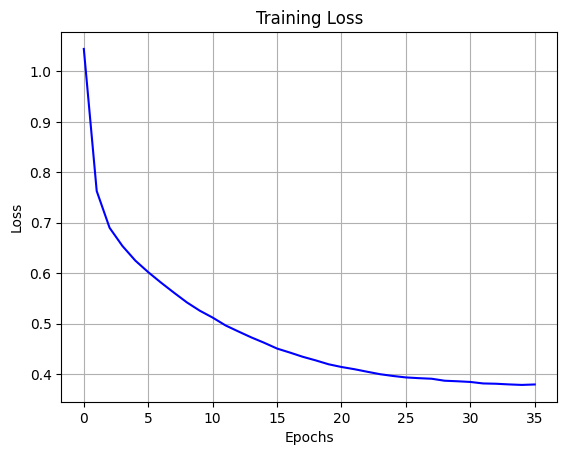

In [7]:
import matplotlib.pyplot as plt
#print(train_loss)
plt.plot(train_loss,color="b")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

In [8]:
# 8. Evaluate Model
true, pred = evaluate_model(model, test_loader, device, le)


--- Starting Evaluation ---
Classification Accuracy: 72.11%

Sample Predictions:
['08:21:ef:3b:fc:e3' '08:21:ef:3b:fc:e3' '08:21:ef:3b:fc:e3' ...
 '74:2f:68:81:69:42' '74:2f:68:81:69:42' '74:2f:68:81:69:42']
@@@@@@@@@@@@@
['00:16:6c:ab:6b:88' '00:16:6c:ab:6b:88' '08:21:ef:3b:fc:e3' ...
 '00:24:e4:10:ee:4c' '00:24:e4:10:ee:4c' '00:24:e4:10:ee:4c']
@@@@@@@@@@@@@
                True MAC      Predicted MAC
0      08:21:ef:3b:fc:e3  00:16:6c:ab:6b:88
1      08:21:ef:3b:fc:e3  00:16:6c:ab:6b:88
2      08:21:ef:3b:fc:e3  08:21:ef:3b:fc:e3
3      08:21:ef:3b:fc:e3  00:16:6c:ab:6b:88
4      08:21:ef:3b:fc:e3  00:16:6c:ab:6b:88
...                  ...                ...
50971  74:2f:68:81:69:42  00:24:e4:10:ee:4c
50972  74:2f:68:81:69:42  00:24:e4:10:ee:4c
50973  74:2f:68:81:69:42  00:24:e4:10:ee:4c
50974  74:2f:68:81:69:42  00:24:e4:10:ee:4c
50975  74:2f:68:81:69:42  00:24:e4:10:ee:4c

[50976 rows x 2 columns]


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
true

array(['08:21:ef:3b:fc:e3', '08:21:ef:3b:fc:e3', '08:21:ef:3b:fc:e3', ...,
       '74:2f:68:81:69:42', '74:2f:68:81:69:42', '74:2f:68:81:69:42'],
      dtype=object)

In [11]:
pred

array(['00:16:6c:ab:6b:88', '00:16:6c:ab:6b:88', '08:21:ef:3b:fc:e3', ...,
       '00:24:e4:10:ee:4c', '00:24:e4:10:ee:4c', '00:24:e4:10:ee:4c'],
      dtype=object)

In [12]:
len(np.unique(true))

25

In [ ]:
from sklearn.metrics import f1_score

f1_weighted = f1_score(true, pred, average='weighted')
print(f"F1 Score (weighted): {f1_weighted:.4f}")

F1 Score (macro): 0.1916
F1 Score (weighted): 0.7231
F1 Score (micro): 0.7211


25   24


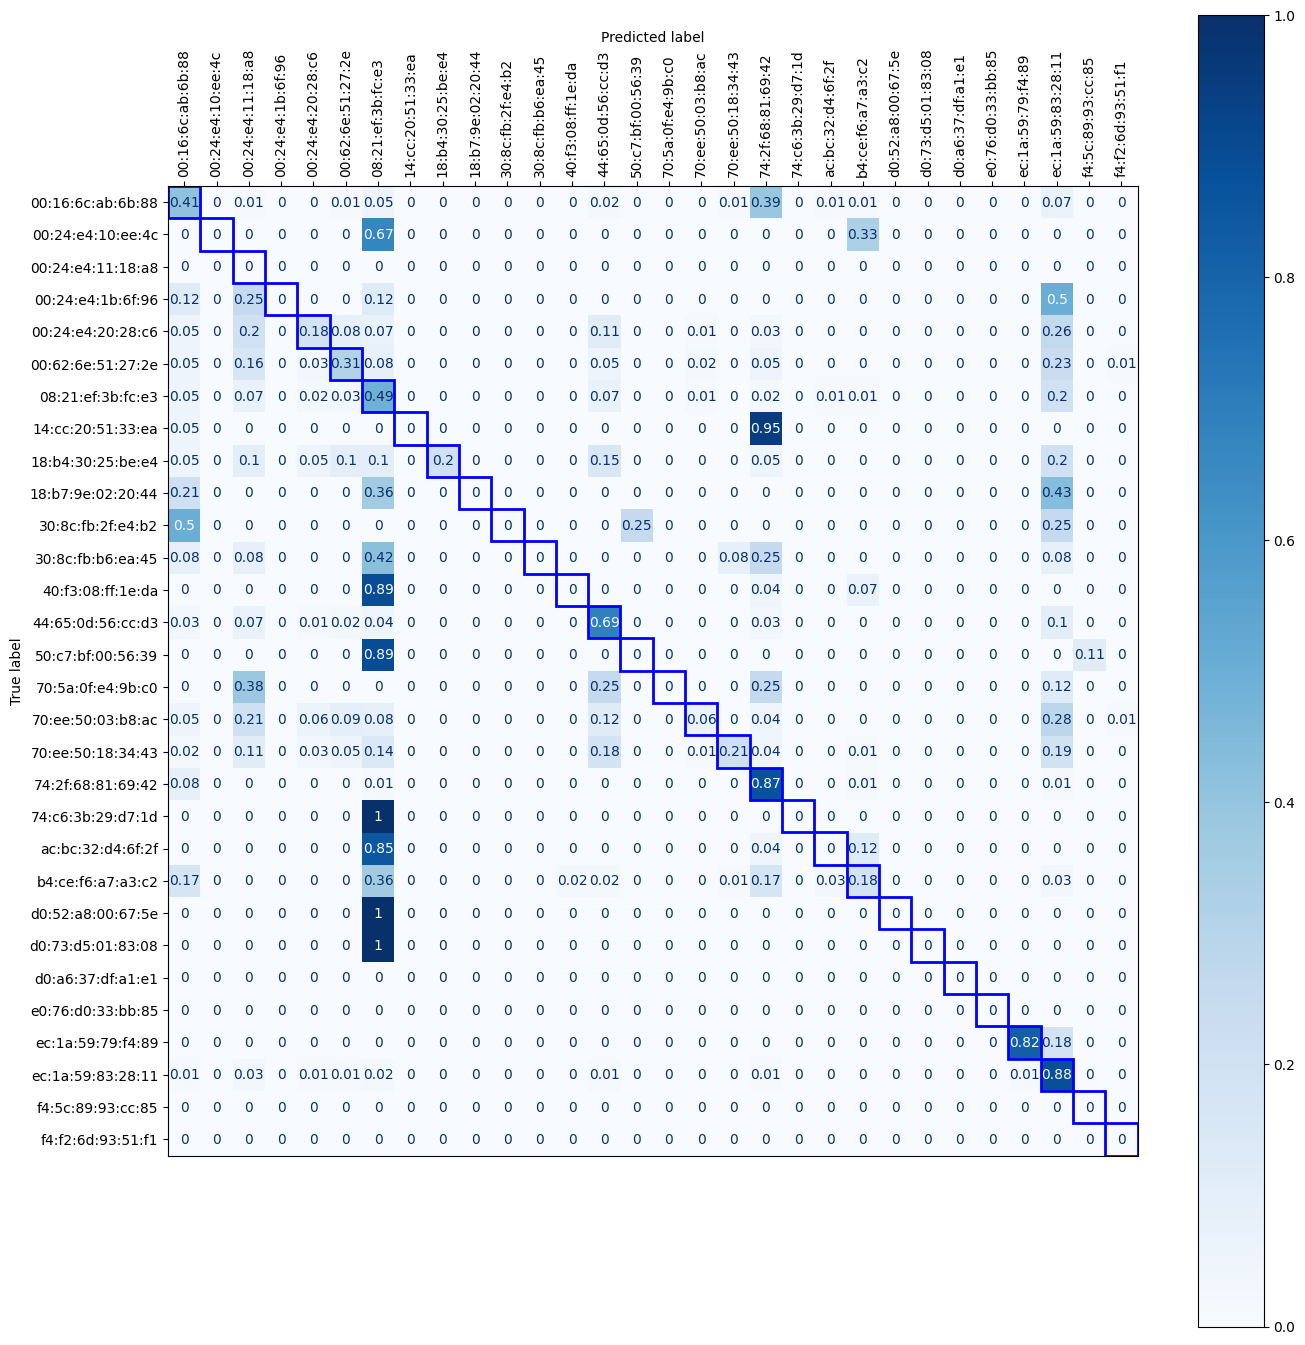

In [ ]:
mapping = {}

labels = sorted(set(true)|set(pred))  # Union of all labels, sorted
print(len(set(true)), " ", len(set(pred)))
cf = confusion_matrix(true,pred,labels=labels,normalize='true')
cf_normalized = np.around(cf,decimals=2)
#cf_normalized= np.around(cf.astype('float') / cf.sum(axis=1)[:, np.newaxis], decimals=2) #normal normalized doesn't round, and .2f doesn't do it that way
#labels = set(pred)
#print(len(labels), " ", len(true))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_normalized,display_labels=labels)

fig, ax = plt.subplots(figsize=(14, 14))
ax.tick_params(
    axis='x',         # Apply to the X-axis
    top=True,         # Show ticks at the top
    labeltop=True,    # Show labels at the top
    bottom=False,     # Hide ticks at the bottom
    labelbottom=False # Hide labels at the bottom
)
ax.xaxis.set_label_position('top')
cm_display.plot(ax=ax, xticks_rotation=90, cmap="Blues")
#box diagonals for better viewing
for i in range(len(labels)):
    ax.add_patch(plt.Rectangle((i-0.5,i-0.5),1,1,fill=False,edgecolor='blue',linewidth=2))
plt.tight_layout()
plt.show()